<a href="https://colab.research.google.com/github/2ovisa/AH2179/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stop ahead prediction
- intressant för resenärer att veta hur stor förseningen blir vid sitt stop
- intressant för resenärer att veta hur stor förseningen är vid sin påstigande station

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split

#-------------------------------------------------data preprocessing------------------------------------------------------------------

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, header = 1)
df.head(10)
#df.shape
#print(df.columns.tolist())

df = df.iloc[:1000]




###Kolumner att droppa:
- Identifiers: Calender_date, route_id, bus_id (innehåller inte nödvändig information
- They who leak future knowledge: Arrival_delay (should be target)
- Dummies: To avoid multi collineraty one of the examples should be dropped. factor(temperature)Normal, (weather)normal, weekend, off-peak. *these become the baseline?*


In [68]:
target = "arrival_delay"
#Create multi-horizon shifted targets
# Assuming stop_sequence roughly corresponds to future steps
#this is a stop-ahead prediction
df["delay_t+1_stop"]  = df.groupby("bus_id")[target].shift(-1)   # next stop
df["delay_t+3_stop"] = df.groupby("bus_id")[target].shift(-3)   # ~3 stops ahead
df["delay_t+6_stop"] = df.groupby("bus_id")[target].shift(-6)
df["delay_t+12_stop"] = df.groupby("bus_id")[target].shift(-12)

#Drop rows with missing target values (at trip ends)
df = df.dropna(subset=["delay_t+1_stop", "delay_t+3_stop", "delay_t+6_stop", "delay_t+12_stop"])





*Why is arrival_delay used and not stop sequence?*
- *stop sequence is just an index telling which stop number in the trip. It only contains ordering, not delay information*
- *the code says "for stop i, the target is the arrival delay at stop i+1*

*this assumes each stop is ~5 minutes apart. If travel times vary a lot, then “t+5 min” might not really equal “next stop”*

In [ ]:
bus_sample = df[df["bus_id"] == df["bus_id"].iloc[0]].sort_values("stop_sequence")

print(bus_sample[["stop_sequence", "arrival_delay",
                  "delay_t+5", "delay_t+15", "delay_t+30", "delay_t+60"]].head(20))

In [ ]:
avg_travel = df["scheduled_travel_time"].mean()
print("Average travel time between stops (seconds):", avg_travel)

In [69]:
# Drop specific columns (Arrival_time, Stop_id, Bus_id, Line_id) from the DataFrame.
df = df.drop(['Calendar_date', 'route_id', 'stop_sequence'], axis=1)
df = pd.get_dummies(df.drop(['factor(weather)Normal', 'factor(temperature)Normal', 'factor(day_of_week)weekend', 'factor(time_of_day)Off-peak'], axis = 1)) #Dummies

#Split into X (features) and y (multi-output)
X = df.drop(['arrival_delay', "delay_t+1_stop", "delay_t+3_stop", "delay_t+6_stop", "delay_t+12_stop"], axis =1)
y = df[["delay_t+1_stop", "delay_t+3_stop", "delay_t+6_stop", "delay_t+12_stop"]]

X = X.astype(int)

# splite the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("X shape:", X.shape)
print("y shape:", y.shape)
print(y.head())

X shape: (783, 25)
y shape: (783, 4)
   delay_t+1_stop  delay_t+3_stop  delay_t+6_stop  delay_t+12_stop
0           185.0           202.0           278.0            358.0
1           186.0           242.0           272.0            367.0
2           202.0           260.0           292.0            374.0
3           242.0           278.0           351.0            394.0
4           260.0           272.0           346.0            424.0


- *if stop_sequence is a freature, the model might cheat by just learning that higher stop numbers mean later in the trip*

KeyError: 'delay_t+stop_1'

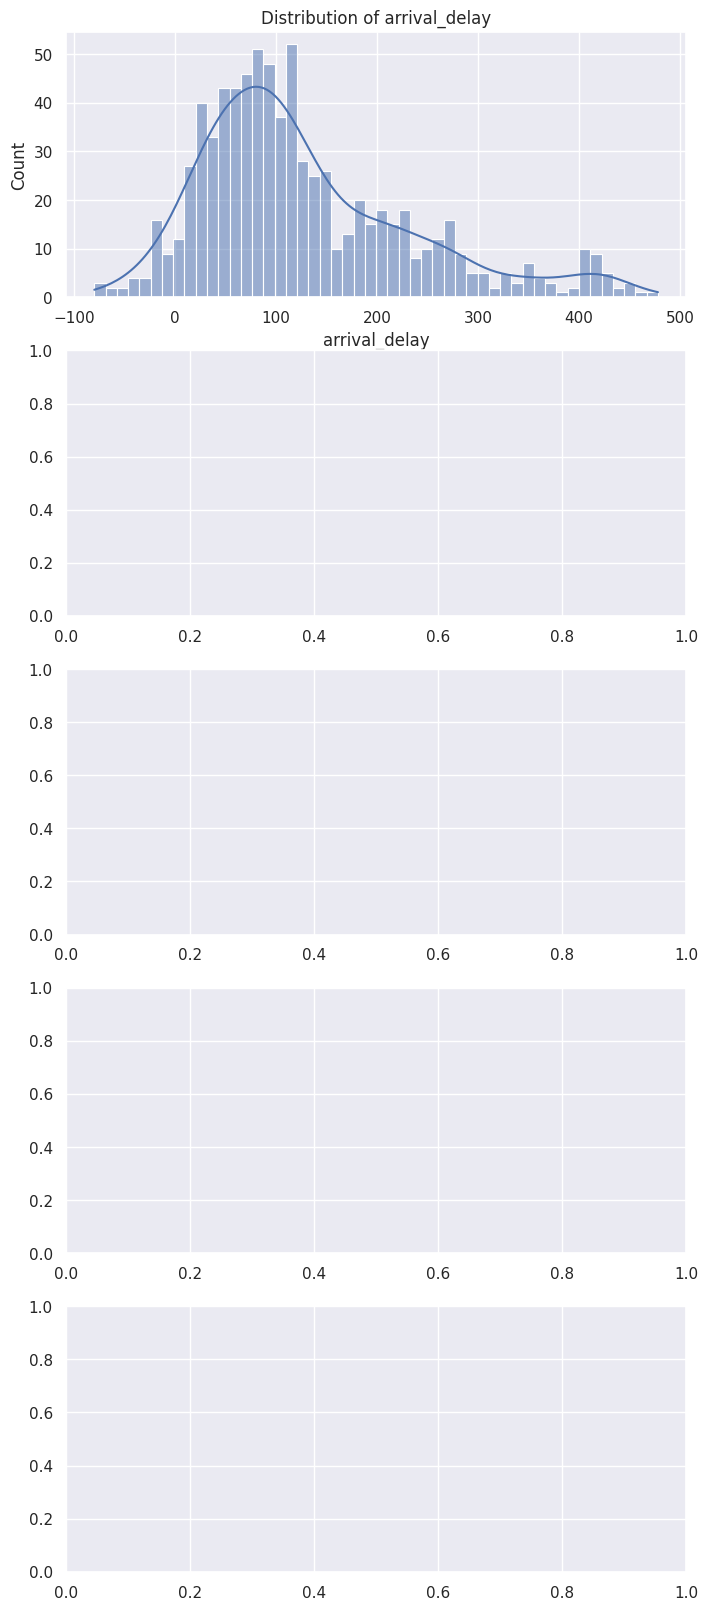

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# List of target columns
targets = ['arrival_delay', "delay_t+1_stop", "delay_t+3_stop", "delay_t+6_stop", "delay_t+12_stop"]

# Create subplots (5 rows, 1 column)
fig, axes = plt.subplots(len(targets), 1, figsize=(8, 20))

# Loop through targets and plot each on its own axis
for i, col in enumerate(targets):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

#sns.histplot(x=df['arrival_delay'])
#sns.histplot(x=df['delay_t+1_stop'])
#sns.histplot(x=df['delay_t+3_stop'])
#sns.histplot(x=df['delay_t+6_stop'])
#sns.histplot(x=df['delay_t+12_stop'])

##Multi-output with KNN

In [ ]:
X_train.dtypes.value_counts()

In [71]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

model = KNeighborsRegressor()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#evaluate
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
for col, score in zip(y.columns, mae):
    print(f"MAE for {col}: {score:.2f}")



MAE for delay_t+1_stop: 34.00
MAE for delay_t+3_stop: 46.54
MAE for delay_t+6_stop: 54.66
MAE for delay_t+12_stop: 56.01


MAE = the average absolute difference between the models predictions and the actual delay

- MAE for delay_t+1_stop: 34.00
- MAE for delay_t+3_stop: 46.54
- MAE for delay_t+6_stop: 54.66
- MAE for delay_t+12_stop: 56.01

This means that on average, the prediction for the next stop is off by 34 seconds.

Interpretations:
- Errors grow as the horizon length increases, which is expected since uncertainty accumulates further into the future


#Visualization

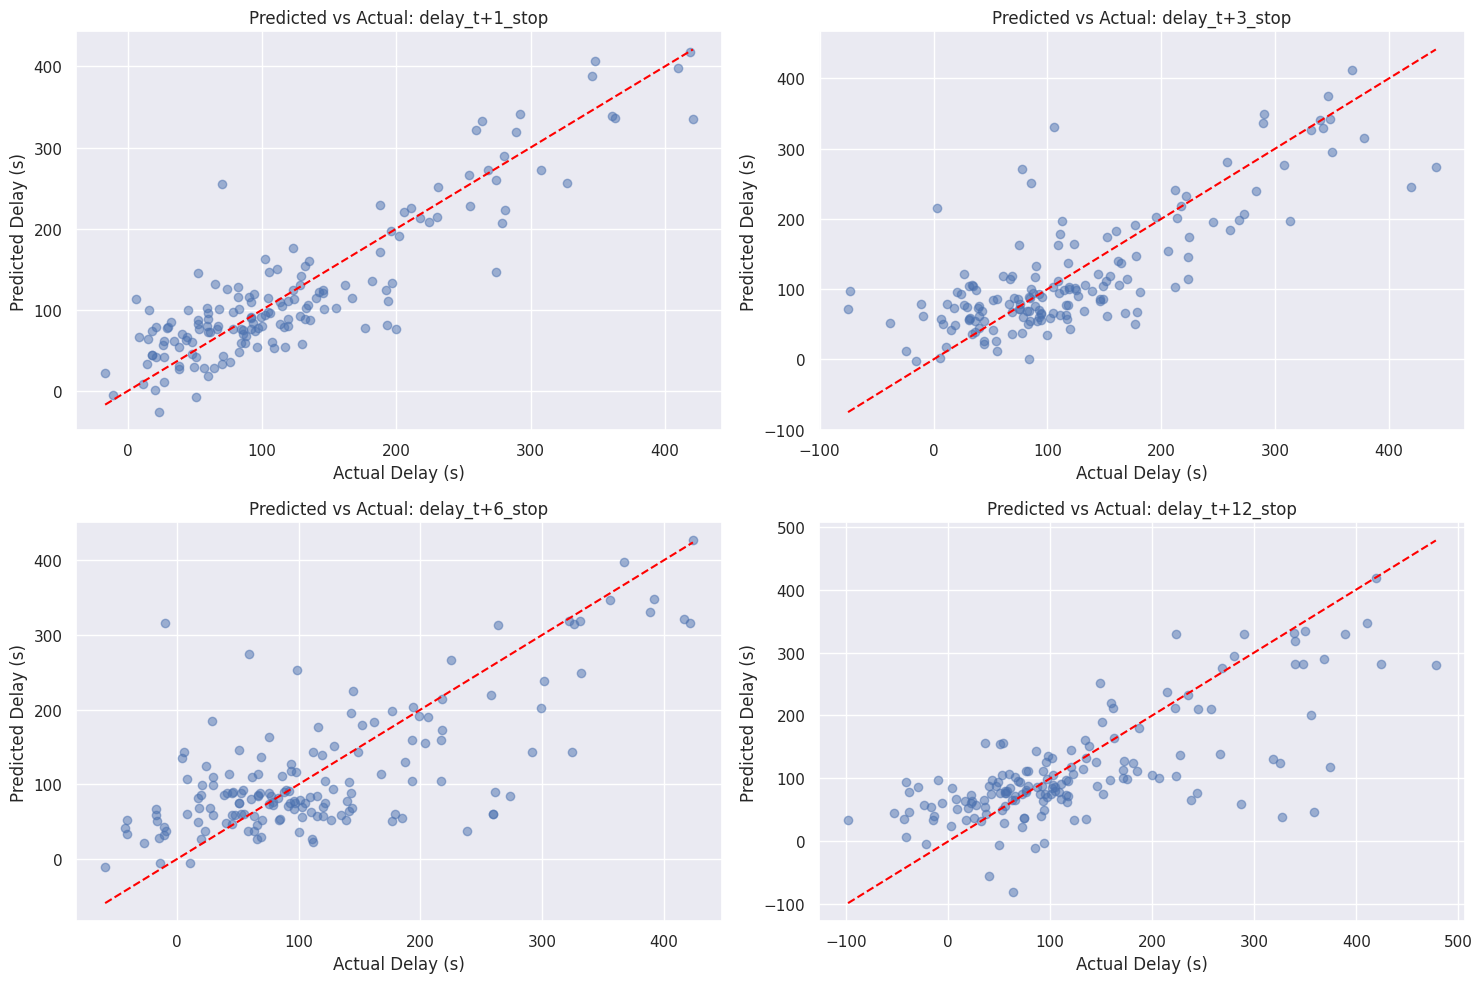

In [72]:
import matplotlib.pyplot as plt

# Define horizons
horizons = ["delay_t+1_stop", "delay_t+3_stop", "delay_t+6_stop", "delay_t+12_stop"]
n_horizons = len(horizons)

plt.figure(figsize=(15, 10))

for i, horizon in enumerate(horizons):
    plt.subplot(2, 2, i+1)
    plt.scatter(y_test[horizon], y_pred[:, i], alpha=0.5)
    plt.plot([y_test[horizon].min(), y_test[horizon].max()],
             [y_test[horizon].min(), y_test[horizon].max()],
             color='red', linestyle='--')  # perfect prediction line
    plt.xlabel("Actual Delay (s)")
    plt.ylabel("Predicted Delay (s)")
    plt.title(f"Predicted vs Actual: {horizon}")

plt.tight_layout()
plt.show()


- *points above the line = overestimations, below = underestimations*

In [ ]:
import matplotlib.pyplot as plt

# Select a single bus trip (bus_id and date) to visualize
trip_id = 41344  # Example bus_id, adjust if needed
trip_data = df[df['bus_id'] == trip_id].sort_values('stop_sequence')

# Assuming y_pred is a NumPy array of predictions for this trip
# Make sure predictions correspond to this trip
predictions = y_pred[:len(trip_data), :]  # adjust indexing if needed

# Horizons
horizons = ["delay_t+5", "delay_t+15", "delay_t+30", "delay_t+60"]

plt.figure(figsize=(12, 6))

for i, horizon in enumerate(horizons):
    plt.plot(trip_data['stop_sequence'], trip_data[horizon], marker='o', label=f'Actual {horizon}')
    plt.plot(trip_data['stop_sequence'], predictions[:, i], marker='x', linestyle='--', label=f'Predicted {horizon}')

plt.xlabel("Stop Sequence")
plt.ylabel("Arrival Delay (s)")
plt.title(f"Delay Propagation Along Stops for Bus {trip_id}")
plt.legend()
plt.grid(True)
plt.show()
